### Import Libraries

In [1]:
from tqdm import tqdm
import seaborn as sns

import rasterio
import xarray
import xrspatial.multispectral as ms
from pandas_path import path

from fastai.vision.all import *

%matplotlib inline

### Setup paths

In [2]:
img_path = Path('data/train_features/')
mask_path = Path('data/train_labels/')

#df = pd.read_csv('data/train_w_meta.csv')
df = pd.read_csv('data/train_metadata.csv')

### Add bands paths to dataframe

In [3]:
## Copied from https://www.drivendata.co/blog/cloud-cover-benchmark/
BANDS = ["B02", "B03", "B04", "B08"]

def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()

    return df

In [4]:
add_paths(df, img_path, mask_path, BANDS)
df.head(1)

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif


In [5]:
chips = df.chip_id.unique()
n = len(chips)

In [6]:
## Get unmodified pixel values
def get_array(filepath):
    return np.array(Image.open(filepath), dtype = np.float32)

### Add image size to dataframe
All bands, per image, should have the same size, so we only check one band.

In [7]:
band = BANDS[0]
for chip in tqdm(chips):
    fn = img_path / chip / f'{band}.tif'
    arr = get_array(fn)
    h, w = arr.shape
    df.loc[df['chip_id'] == chip, 'width'] = w
    df.loc[df['chip_id'] == chip, 'height'] = h

100%|██████████| 11748/11748 [00:54<00:00, 213.88it/s]


In [8]:
print(f'Unique widths: {df.width.unique()}, unique heights: {df.height.unique()}')

Unique widths: [512.], unique heights: [512.]


So all images are of size 512 $\times$ 512.

### Calculate different pixel value meta data
We want to capture the per image minimum/maximum/min-max-range and also the per band mean and the standard deviation to check if its suitable to normalize the images by them.
Since all images have the same dimensions, we can calculate the mean pixel value per image and receive the overall mean by averaging over all of those, since:
$$ \frac{1}{m} \sum_{i=1}^m x_i = \frac{1}{n}\sum_{k=1}^n \frac{1}{512 \cdot 512} \sum_{1\leq i,j\leq 512} X^k_{i,j}$$
for the number of images $n$, the total number of pixels $m = n \cdot 512 \cdot 512$ and $X^k$ the $k$-th image.

The standard deviation uses the per band mean, so we calculate it separate from the mean.

In [9]:
def add_array_meta():
    for band in BANDS:
        print(f'Processing band: {band}\n')
        for chip in tqdm(chips):
            loc_chip = df['chip_id'] == chip

            fn = df.loc[loc_chip, f'{band}_path'].item()
            arr = get_array(fn)
            
            min_val = arr.min()
            max_val = arr.max()
            
            df.loc[loc_chip, f'{band}_min'] = min_val
            df.loc[loc_chip, f'{band}_max'] = max_val
            df.loc[loc_chip, f'{band}_range'] = max_val - min_val
            df.loc[loc_chip, f'{band}_rel_range'] = (max_val - min_val) / max_val
            df.loc[loc_chip, f'{band}_mean'] = arr.mean()

In [10]:
add_array_meta()

  0%|          | 33/11748 [00:00<00:36, 321.53it/s]

Processing band: B02



  0%|          | 25/11748 [00:00<00:48, 239.94it/s]

Processing band: B03



  0%|          | 21/11748 [00:00<00:57, 205.22it/s]

Processing band: B04



  0%|          | 20/11748 [00:00<00:58, 199.07it/s]

Processing band: B08



100%|██████████| 11748/11748 [01:05<00:00, 179.19it/s]


In [11]:
df.head(1)

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path,width,...,B04_min,B04_max,B04_range,B04_rel_range,B04_mean,B08_min,B08_max,B08_range,B08_rel_range,B08_mean
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif,512.0,...,556.0,8928.0,8372.0,0.937724,1987.291138,534.0,8488.0,7954.0,0.937088,1550.722534


### Calculate per band max & mean and save to dict

In [12]:
meta_dict = {}

In [13]:
max_cols = [col for col in df.columns if '_max' in col]
maxs_dict = df[max_cols].max().to_dict()

mean_cols = [col for col in df.columns if '_mean' in col]
means_dict = df[mean_cols].mean().to_dict()

In [14]:
meta_dict['maxs'] = {band:round(maxs_dict[f'{band}_max'],3) for band in BANDS}
meta_dict['means'] = {band:round(means_dict[f'{band}_mean'],3) for band in BANDS}
meta_dict

{'maxs': {'B02': 27600.0, 'B03': 26096.0, 'B04': 23104.0, 'B08': 19568.0},
 'means': {'B02': 2848.064, 'B03': 2839.087, 'B04': 2741.289, 'B08': 3657.909}}

### Prepare for standard deviation

Test this method for high pixel values in the calculation of the variance. In some cases it might be computationally better to calculate the variance described as below. _It actually seems not to be needed here._

The variance is defined as:
$$ \sigma(x)^2 = \text{Var}(x) = \frac{1}{m} \cdot \sum_{i=1}^{m} (x_i - \mu)^2 $$
where $ m = n \cdot 512 \cdot 512$ is again the total number of pixels per band with $n$ the number of images.
Then the above equation can be written as:
$$ \text{Var}(x) %= \frac{1}{k} \cdot \sum_{k = 1}^n \frac{1}{512\cdot512} \sum_{1 \leq i,j \leq 512} (X_{i,j}^k - \mu)^2 \\
                 %= \frac{1}{k} \cdot \sum_{k = 1}^n \sum_{1 \leq i,j \leq 512} \frac{(X_{i,j}^k - \mu)^2}{512^2}  \\
                 = \frac{1}{k} \cdot \sum_{k = 1}^n \sum_{1 \leq i,j \leq 512} (\frac{X_{i,j}^k - \mu}{512})^2.
$$
So we can precompute the weighted sums:
$$ \sum_{1 \leq i,j \leq 512} (\frac{X_{i,j}^k - \mu}{512})^2 $$
for all images $X^k$ and receive the variance by calculating the mean of those weighted sums.

In [15]:
def custom_variance(arr, mean):
    return np.sum(np.square((arr - mean)/512.))

In [16]:
def add_custom_var():
    for band in BANDS:
        print(f'Processing band: {band}')
        for chip in tqdm(chips):
            fn = df.loc[df['chip_id'] == chip, f'{band}_path'].item()
            arr = get_array(fn)
            
            df.loc[df['chip_id'] == chip, f'{band}_var'] = custom_variance(arr, meta_dict['means'][band])

In [17]:
add_custom_var()

  0%|          | 6/11748 [00:00<03:16, 59.62it/s]

Processing band: B02


  0%|          | 10/11748 [00:00<02:05, 93.37it/s]

Processing band: B03


  0%|          | 20/11748 [00:00<00:59, 198.24it/s]

Processing band: B04


  0%|          | 22/11748 [00:00<00:55, 211.82it/s]

Processing band: B08


100%|██████████| 11748/11748 [01:01<00:00, 190.48it/s]


### Calculate per band standard deviation

In [18]:
var_cols = [col for col in df.columns if '_var' in col]
var_dict = np.sqrt(df[var_cols].mean()).to_dict()
meta_dict['stds'] = {band:round(var_dict[f'{band}_var'], 3) for band in BANDS}

In [19]:
meta_dict

{'maxs': {'B02': 27600.0, 'B03': 26096.0, 'B04': 23104.0, 'B08': 19568.0},
 'means': {'B02': 2848.064, 'B03': 2839.087, 'B04': 2741.289, 'B08': 3657.909},
 'stds': {'B02': 3156.927, 'B03': 2899.28, 'B04': 2789.962, 'B08': 2424.189}}

### Check the distributions of the minimal/maximal values over all instances

In [21]:
def show_distribution(df, aggr):
    fig, axs = plt.subplots(2, 2, figsize = (20, 15))
    axs = axs.flatten()
    for i,band in enumerate(BANDS):
        fig.suptitle('Distribution of the minimal values over all instances, grouped by band', fontsize=20)
        sns.histplot(df[f'{band}_{aggr}'], ax = axs[i], bins=100)
        axs[i].set_title(f'min_value: {int(df[f"{band}_{aggr}"].min())} | max_value: {int(df[f"{band}_{aggr}"].max())}')
    plt.show()

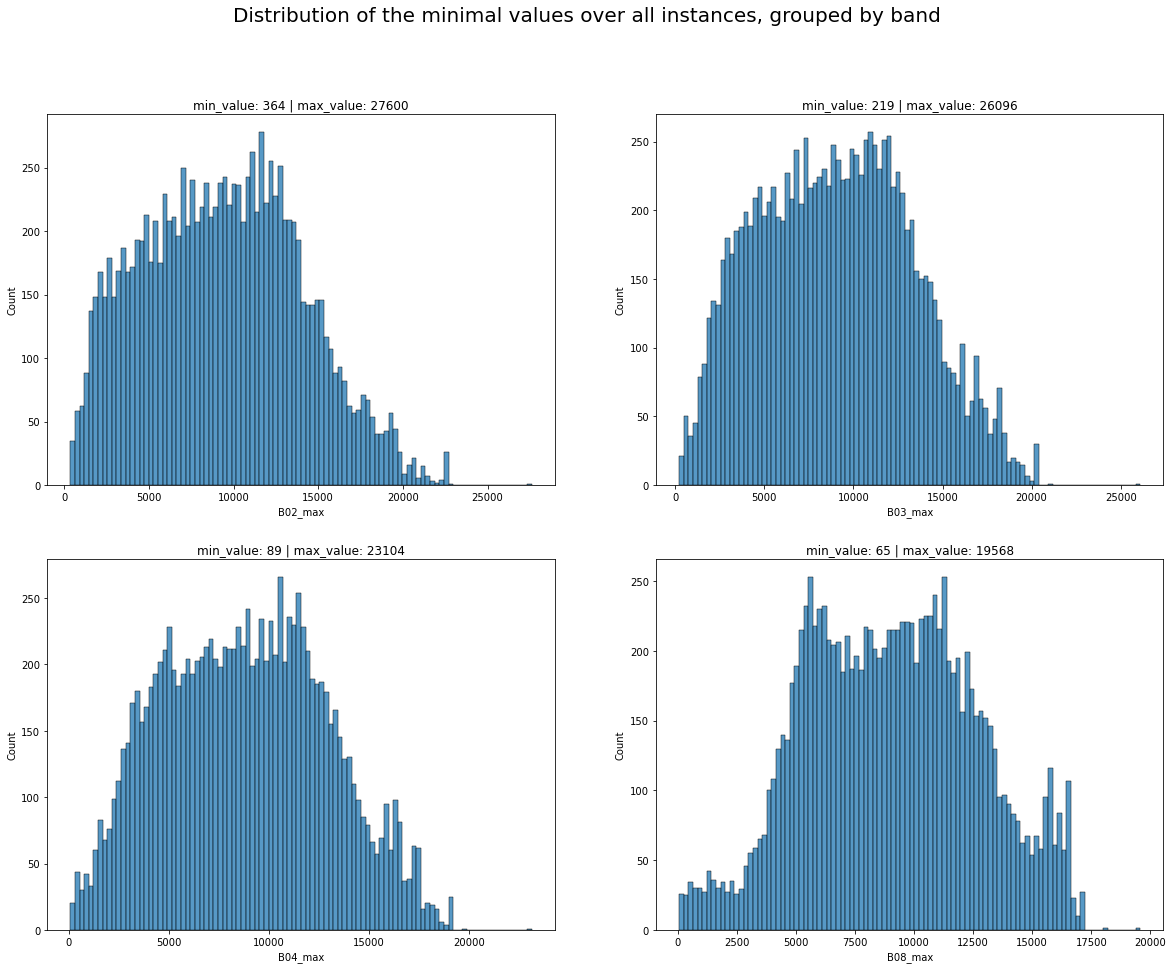

In [22]:
show_distribution(df, 'max')

In [23]:
df[df['B08_max'] > 17500]

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path,width,...,B04_mean,B08_min,B08_max,B08_range,B08_rel_range,B08_mean,B02_var,B03_var,B04_var,B08_var
7633,rxqz,Ghana,2019-02-16T10:39:11Z,az://./train_features/rxqz,data/train_features/rxqz/B02.tif,data/train_features/rxqz/B03.tif,data/train_features/rxqz/B04.tif,data/train_features/rxqz/B08.tif,data/train_labels/rxqz.tif,512.0,...,2558.134521,955.0,18048.0,17093.0,0.947086,3991.861328,12844534.0,10217393.0,8937140.0,5136580.5
7726,saex,Ghana,2019-02-16T10:39:11Z,az://./train_features/saex,data/train_features/saex/B02.tif,data/train_features/saex/B03.tif,data/train_features/saex/B04.tif,data/train_features/saex/B08.tif,data/train_labels/saex.tif,512.0,...,2748.674561,237.0,19568.0,19331.0,0.987888,4214.380859,16411173.0,13660302.0,12173546.0,7594227.0


### Show images

In [24]:
## With failsave if band doesnt exist (for validation/test set)
def get_array(chip_path, band):
    fn = (chip_path / band).with_suffix('.tif')
    if fn.exists():
        arr = np.asarray(Image.open(fn), dtype = np.float32)
        return arr
    else:
        return np.zeros((512, 512))

In [25]:
def get_multiband_img(chip_path):
    # Normalization by mean/std
    blue  = (get_array(chip_path, 'B02') - meta_dict['means']['B02']) / meta_dict['stds']['B02']
    green = (get_array(chip_path, 'B03') - meta_dict['means']['B03']) / meta_dict['stds']['B03']
    red   = (get_array(chip_path, 'B04') - meta_dict['means']['B04']) / meta_dict['stds']['B04']
    infra = (get_array(chip_path, 'B08') - meta_dict['means']['B08']) / meta_dict['stds']['B08']
    
    stack = np.stack([red, green, blue, infra], axis = -1) # resulting size:(width,height,bands)
    return stack

When looking at the images, we are only interested in the 3 visual bands.

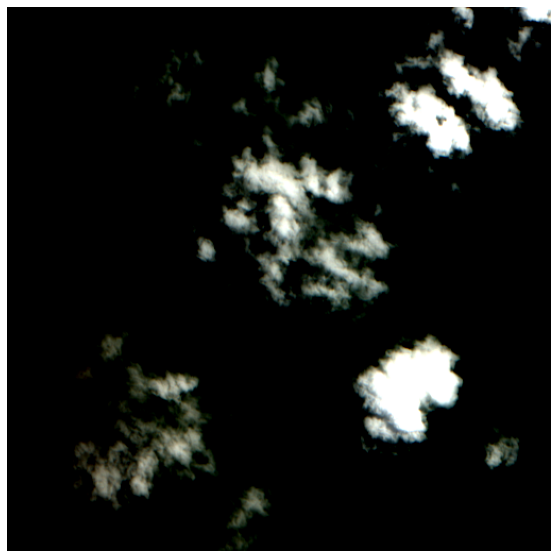

In [26]:
img = get_multiband_img(img_path / chips[0])
plt.figure(figsize = (10,10))
plt.imshow(np.clip(img[...,:3], 0, 1))
plt.axis('off');

Most images get quiet dark from the mean-std-normalization. We want to keep the normalization since it might help with training, so we min-max-scale the values to $[0,1]$ for visualization, which shows enough to evaluate the model results. It should be checked if that is the best normalization for the dataset!

In [27]:
def show_viz(img, figsize = None):
    if not figsize:
        figsize = (10, 10)
    elif type(figsize) == int:
        figsize = (figsize, figsize)
    plt.figure(figsize = figsize)
    
    img = img[...,:3]
    max_values = img.max(axis=(0,1))
    min_values = img.min(axis=(0,1))
    img = (img - min_values )/(max_values - min_values)

    plt.imshow(img)
    plt.axis('off')

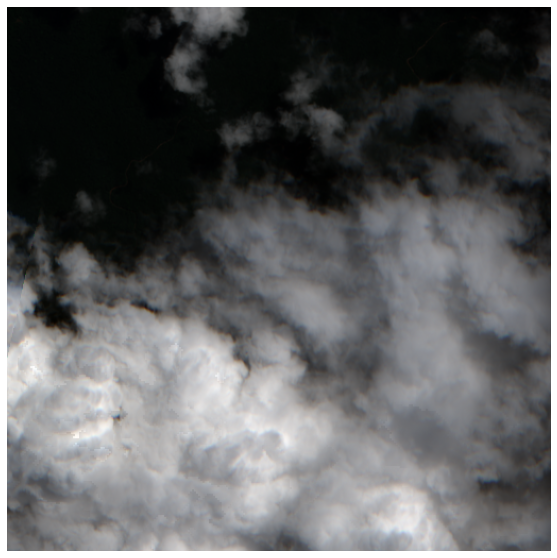

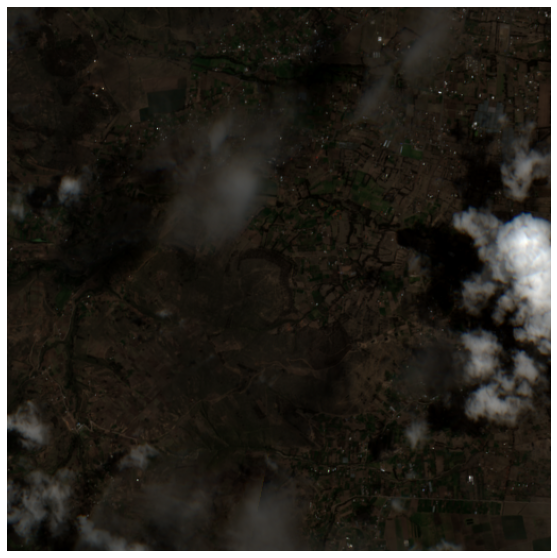

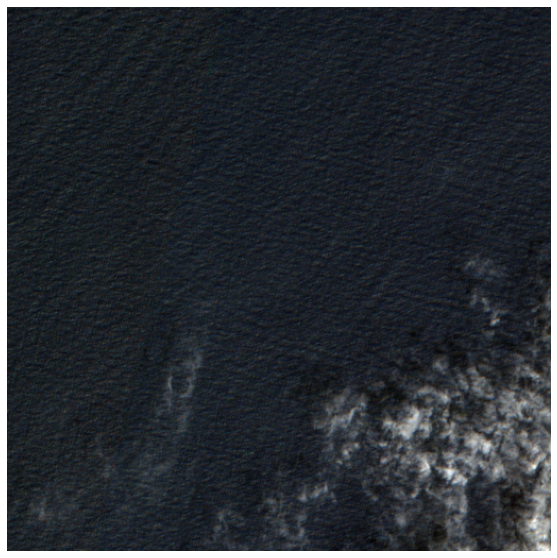

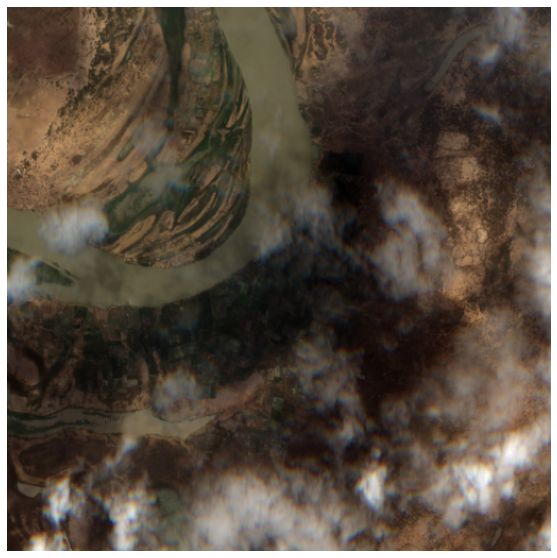

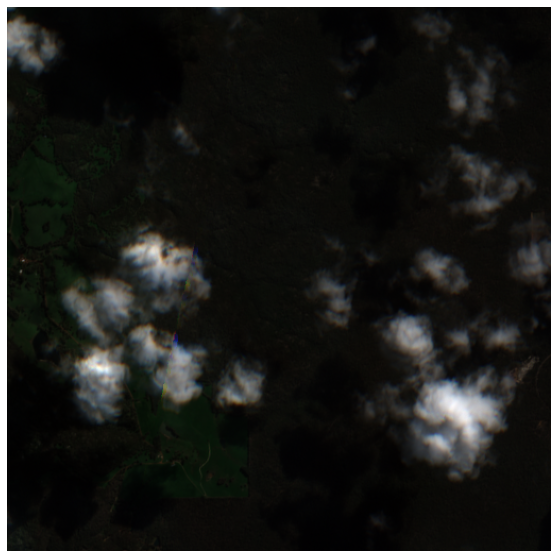

In [28]:
for chip in np.random.choice(chips, size = 5):
    img = get_multiband_img(img_path / chip)
    show_viz(img)
    plt.show()

### Remove unused columns and save the dataframe

In [36]:
drop_cols = [col for col in df.columns if '_var' in col] # "var" only used as  intermediate step 
drop_cols += ['width', 'height'] # all the same, so not useful
drop_cols += ['cloudpath'] # not used
df = df.drop(drop_cols, axis = 1)

In [37]:
df.to_csv('data/train_final.csv')